In [12]:
import pandas as pd
import numpy as np
from congress import Congress
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from congress import CongressError
import os
#import pygraphviz
import seaborn as sns

from networkx.drawing.nx_agraph import graphviz_layout
import graphviz

In [2]:
congress = Congress('rsDVQCxE9vexRoqau9VTUMnRgxRHkYyDzPX1I6QZ')
house = congress.members.filter('house') # or house
df_house = pd.DataFrame.from_dict(house[0]['members'])
member_ids = list(df_house.id)

In [3]:
df_house.columns

Index(['api_uri', 'at_large', 'contact_form', 'crp_id', 'cspan_id',
       'date_of_birth', 'district', 'dw_nominate', 'facebook_account', 'fax',
       'fec_candidate_id', 'first_name', 'gender', 'geoid', 'google_entity_id',
       'govtrack_id', 'icpsr_id', 'id', 'ideal_point', 'in_office',
       'last_name', 'leadership_role', 'middle_name', 'missed_votes',
       'missed_votes_pct', 'next_election', 'ocd_id', 'office', 'party',
       'phone', 'rss_url', 'seniority', 'short_title', 'state', 'suffix',
       'title', 'total_present', 'total_votes', 'twitter_account', 'url',
       'votes_with_party_pct', 'votesmart_id', 'youtube_account'],
      dtype='object')

In [4]:
fullname = df_house.first_name + " " + df_house.last_name

In [9]:
len(member_ids)

449

# Downloading the data

In [11]:
member1_id = []
member2_id=[]
congress_nr = []
common_votes = []
disagree_votes = []
agree_percent = []
disagree_percent = []
index = []

list_used = []


count = 1
idx=1
for i in member_ids[:20]:
    try:
        for g in member_ids[:20]:
            if g !=i:
                if g not in list_used:
                    list_used.append(i)
                        
                    data_tmp = congress.members.compare(first=i,second=g,chamber='house')

                    member1_id.append(i)
                    member2_id.append(g)
                    congress_nr.append(data_tmp['congress'])
                    common_votes.append(data_tmp['common_votes'])
                    disagree_votes.append(data_tmp['disagree_votes'])
                    agree_percent.append(data_tmp['agree_percent'])
                    disagree_percent.append(data_tmp['disagree_percent'])
                    index.append(idx)
                    
                    idx+=1

                    time.sleep(0.1)
                print('-', end='')
                        
    except(CongressError, RuntimeError, TypeError, NameError, ZeroDivisionError, IndexError) as e:
        print(e, end=' ') # printing the name of the error
        continue
    
    
    df = pd.DataFrame(
        {'disagree_percent': disagree_percent,
         'agree_percent': agree_percent,
         'disagree_votes': disagree_votes,
         'common_votes':common_votes,
         'congress_nr':congress_nr,
         'member2_id':member2_id,
         'member1_id':member1_id,
         }, index=index
    )

    filename = 'C:/Users/Asger/Dropbox/Økonomi/Topics in Social Data Science/Projekt/Data/member_nr_'+str(count)+'_'+str(i)+'.csv'
    #filename = 'C:/Users/Asger/Dropbox/Økonomi/Topics in Social Data Science/Projekt/Data/test.csv'
    df.to_csv(filename, encoding='utf-8', header=True)
    print('Member nr '+str(count)+', '+ str(i) + ', is saved')
    
    count +=1


-------------------Member nr 1, A000374, is saved
-------------------Member nr 2, A000370, is saved
-------------------Member nr 3, A000055, is saved
-------------------Member nr 4, A000371, is saved
-------------------Member nr 5, A000372, is saved
-------------------Member nr 6, A000367, is saved
-------------------Member nr 7, A000369, is saved
-------------------Member nr 8, A000375, is saved
-------------------Member nr 9, B001291, is saved
-------------------Member nr 10, B001298, is saved
-------------------Member nr 11, B001299, is saved
-------------------Member nr 12, B001269, is saved
-------------------Member nr 13, B001282, is saved
-------------------Member nr 14, B001300, is saved
-------------------Member nr 15, B000213, is saved
-------------------Member nr 16, B001270, is saved
-------------------Member nr 17, B001281, is saved
-------------------Member nr 18, B000287, is saved
-------------------Member nr 19, B001287, is saved
-------------------Member nr 20, B001301

## Loading the data

In [5]:
# Loading the files:
os.chdir('C:/Users/Asger/Dropbox/Økonomi/Topics in Social Data Science/Projekt/Data/')

data= []
path = r'C:/Users/Asger/Dropbox/Økonomi/Topics in Social Data Science/Projekt/Data/'
for root, dirs, files  in os.walk(path, topdown=False):
    for i in files:
        data.append(pd.read_csv(i, index_col=0))
    
df_data = pd.concat(data)
len(df_data)

2660

In [16]:
df_data.head()

,agree_percent,common_votes,congress_nr,disagree_percent,disagree_votes,member1_id,member2_id
1,25.59,848,115,74.41,631,A000374,A000370
2,96.56,844,115,3.44,29,A000374,A000055
3,28.82,864,115,71.18,615,A000374,A000371
4,97.81,868,115,2.19,19,A000374,A000372
5,72.25,872,115,27.75,242,A000374,A000367


## Network

In [6]:
repulicans = [i for i in list(df_house[df_house.party == "R"]["id"]) if i] # remove None_type hack -> men none types er vel indies
democrats = [i for i in list(df_house[df_house.party == "D"]["id"]) if i] # remove None_type hack

In [7]:
#Finding all the nodes:
df_edges = df_data.loc[df_data['agree_percent'] > 97]
edges = list(zip(df_edges.member1_id, df_edges.member2_id))
len(edges)

207

In [8]:
G = nx.Graph()
G.add_edges_from(edges) # Indies må komme herfra! Der må være edges som du ikke har nodes på....
G.add_nodes_from(repulicans, party = "R", party_int = 0)
G.add_nodes_from(democrats, party = "D", party_int = 1)

no_party = []

for i, p in list(G.nodes(data=True)):
    if len(p) == 0:
        no_party.append(i)
        
G.remove_nodes_from(no_party) # det er nok det her der burde ske.. men så skal low_degree ind efter...

#G.add_nodes_from(no_party, party = "non", party_int = 2)


low_degree = []

for i in list(G.degree()):
    if i[1] < 1: # a bit high..
        low_degree.append(i[0])
        
G.remove_nodes_from(low_degree)


R_nodes = [n for n, p in list(G.nodes(data=True)) if p['party'] == 'R']
D_nodes =  [n for n, p in list(G.nodes(data=True)) if p['party'] == 'D']
#N_nodes =  [n for n, p in list(G.nodes(data=True)) if p['party'] == 'non']

In [9]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 13\nNumber of edges: 15\nAverage degree:   2.3077'

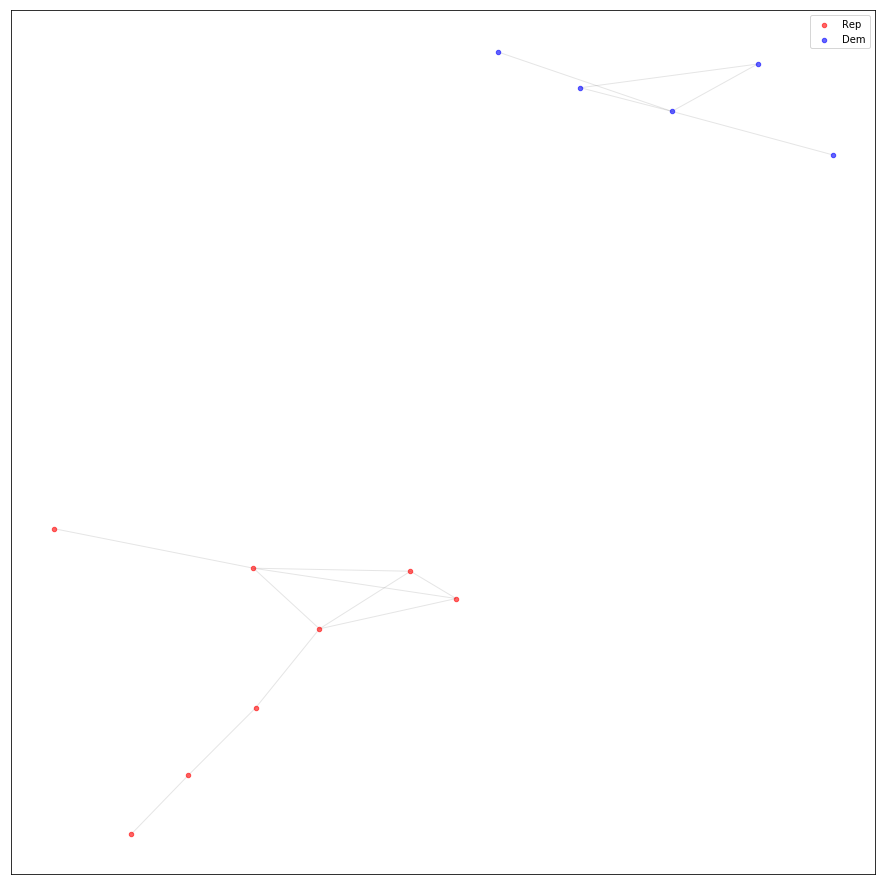

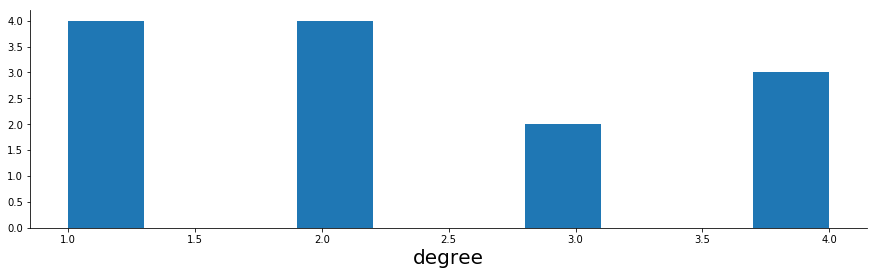

0.3974358974358974
13
15


In [13]:
plt.axes([2,3,2,3])

#nx.draw(G, with_labels=True, font_weight='bold', alpha=0.6, pos = graphviz_layout(G))

#pos = graphviz_layout(G)
pos = nx.spring_layout(G)

nx.draw_networkx_edges(G, node_size=12, alpha = 0.1, pos=pos)

nx.draw_networkx_nodes(G, font_size=8, nodelist=R_nodes , node_size=20, node_color="red", alpha = 0.6, pos=pos, label = "Rep")
nx.draw_networkx_nodes(G, font_size=8, nodelist=D_nodes , node_size=20, node_color="blue", alpha = 0.6, pos=pos, label = "Dem")
#nx.draw_networkx_nodes(G, font_size=8, nodelist=N_nodes , node_size=20, node_color="cyan", alpha = 0.6, pos=graphviz_layout(G), label = "Indie") 

plt.legend()
plt.xticks(())
plt.yticks(())
#sns.despine(left=True, bottom=True)

plt.savefig('net170.pdf', bbox_inches="tight")
plt.show()

#----------------------------------------------------

plt.figure(figsize=[15,4])

plt.hist(list(dict(G.degree()).values()))#, bins=np.arange(0,10,1), density=True, alpha = 0.6)

#sns.kdeplot(list(dict(G.degree()).values()), label = "kde (bw = 0.4)", bw=0.4, color="darkorange")
#G_norm = stats.norm(np.mean(list(dict(G.degree()).values())),np.std(list(dict(G.degree()).values())))
#grid = np.arange(0,30,0.1)
#plt.plot(grid,G_norm.pdf(grid), color = "darkblue", label = "normal distribution")

#plt.xlim(1,10)
plt.xlabel("degree", fontsize = 20)
sns.despine()

plt.show()

#nx.write_gexf(G, "small_set.gexf", version="1.2draft")

print(nx.average_clustering(G)) # tolkning, tak.
print(len(G.nodes()))
print(len(G.edges()))